Boilerplate Connection Setup
---

In [1]:
%%vertica

SET TIME ZONE 'UTC'

First figure out the most recent transaction we have available for analysis in the data warehouse.

In [2]:
%%vertica -> last_transaction_date_df
SELECT
    MAX(order_timestamp)::DATE AS last_transaction_date
FROM
    finance.f_orderitem_transactions f
WHERE
    f.transaction_type IS NOT NULL
    AND f.order_username IS NOT NULL
    AND f.partner_short_code = 'edx'

In [3]:
import datetime
from dateutil.tz import tzutc

experiment_id = 8449172827
experiment_start = datetime.datetime(2017, 6, 26, 0, tzinfo=tzutc())
experiment_end_time = datetime.datetime(2017, 7, 13, 0, tzinfo=tzutc())

last_transaction_date = last_transaction_date_df.loc[0][0]
transaction_cutoff = datetime.datetime(
    last_transaction_date.year, last_transaction_date.month, last_transaction_date.day, 0, tzinfo=tzutc()
)

First grab all experiment views and put them in a table. Note that the "Experiment Viewed" event is fired when the experiment is paused, so we hardcode in the time we paused the experiment here.

In [4]:
# %%vertica (experiment_id, experiment_end_time)
# CREATE TABLE IF NOT EXISTS ret.experiment_views
# (
#     received_at TIMESTAMPTZ,
#     timestamp TIMESTAMPTZ,
#     anonymous_id VARCHAR,
#     raw_user_id VARCHAR,
#     user_id INT,
#     experiment_id INT,
#     experiment_name INT,
#     variation_id INT,
#     variation_name INT,
#     course_id VARCHAR,
#     path VARCHAR,
#     url VARCHAR
# );

# INSERT INTO ret.experiment_views
# SELECT
#     event.received_at::TIMESTAMPTZ,
#     event.timestamp::TIMESTAMPTZ,
#     event.anonymous_id,
#     event.user_id AS raw_user_id,
#     CASE
#         WHEN REGEXP_LIKE(event.user_id, '^\d+$') THEN event.user_id::INT
#         ELSE NULL
#     END AS user_id,
#     event.experimentid::INT AS experiment_id,
#     event.experimentname AS experiment_name,
#     event.variationid::INT AS variation_id,
#     event.variationname AS variation_name,
#     CASE 
#         WHEN STRPOS(event.path, '%') = 0
#             THEN REGEXP_SUBSTR(event.path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1)
#         ELSE URI_PERCENT_DECODE(
#             REGEXP_SUBSTR(event.path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1)
#         )
#     END AS course_id,
#     event.path,
#     event.url
# FROM
#     experimental_events_run14.event_records event
# LEFT JOIN ret.experiment_views AS ev ON
#         ev.received_at = event.received_at :: TIMESTAMPTZ
#     AND ev.timestamp = event.timestamp :: TIMESTAMPTZ
#     AND ev.raw_user_id = event.user_id
#     AND ev.experiment_id = event.experimentid
#     AND ev.variation_id = event.variationid
#     AND ev.course_id = event.course_id
# WHERE
#         event_type = 'Experiment Viewed'
#     AND event.experimentid = :experiment_id
#     AND event.received_at::TIMESTAMPTZ < :experiment_end_time::TIMESTAMPTZ
#     AND ev.experiment_id IS NULL
# ;

# Check for users that saw multiple variations

Check how many users saw multiple variations within the same course, we will exclude these enrollments from our significance calculation.

In [5]:
%%vertica (experiment_id) -> variations_per_user
SELECT
    user_id,
    course_id,
    MIN(variation_name) AS variation_name,
    COUNT(DISTINCT variation_name) AS variations_per_enrollment
FROM
    ret.experiment_views
WHERE
    experiment_id = :experiment_id
GROUP BY 1, 2

In [6]:
num_users = variations_per_user.groupby('variations_per_enrollment').count()
total_users = num_users.user_id.sum()
num_users['percent_of_population'] = (num_users.user_id / float(total_users)) * 100
num_users[['user_id', 'percent_of_population']]

,user_id,percent_of_population
variations_per_enrollment,,
1,299496,91.316438
2,24028,7.326146
3,3524,1.074469
4,928,0.282948


It looks like roughly 91% of our users only saw one variation in each course. Let's remove the other 9% from our analysis.

In [7]:
variations_per_user[variations_per_user.variations_per_enrollment == 1].groupby('variation_name').count()[['user_id']]

,user_id
variation_name,
Fixed Footer,74705
Original,75360
Polite Footer,74558
The Sock,74873


Just checking, it looks like even when we remove the users that saw multiple variants per course, the group sizes are roughly equivalent.

## Bookings and conversions by user and test group

In [8]:
%%vertica (transaction_cutoff, experiment_id, experiment_end_time) -> conversions

-- This query should return one record per enrollment.
SELECT
    viewed.user_id,
    viewed.course_id,
    viewed.variation_name,
    course.pacing_type,
    purchased.purchase_time,
    COALESCE(purchased.cnt_sales, 0) AS cnt_sales,
    COALESCE(purchased.net_bookings, 0)::FLOAT AS net_bookings,
    COALESCE(purchased.gross_bookings, 0)::FLOAT AS gross_bookings,
    COALESCE(purchased.gross_refunds, 0)::FLOAT AS gross_refunds,
    COALESCE(purchased.cnt_sales, 0)::FLOAT AS cnt_sales,
    COALESCE(purchased.cnt_refunds, 0)::FLOAT AS cnt_refunds
FROM

-- This subquery gathers all enrollments who have been exposed to exactly one variant
(
    SELECT
        user_id,
        course_id,
        MIN(variation_name) AS variation_name,
        MIN(received_at) AS exposure_time
    FROM
        ret.experiment_views
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT variation_name) = 1
) AS viewed

-- Need to join with d_user to get their username
JOIN production.d_user du ON du.user_id = viewed.user_id

-- Need to join with d_course to get the pacing_type for the course
JOIN production.d_course course ON course.course_id = viewed.course_id

-- Now join with our finance table to find all sales and refunds for this user that are *after* the first exposure
LEFT JOIN
(
    -- This gathers all transactions associated with an enrollment and pins them to the first transaction time.
    -- This should return one record per enrollment.
    SELECT
        f.order_username AS username,
        f.order_course_id AS course_id,
        MIN(f.order_timestamp)::TIMESTAMPTZ AS purchase_time,
        SUM(f.transaction_amount_per_item) AS net_bookings,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_bookings,
        SUM(CASE WHEN f.transaction_type = 'refund' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_refunds,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN 1 ELSE 0 END) AS cnt_sales,
        SUM(CASE WHEN f.transaction_type = 'refund' THEN 1 ELSE 0 END) AS cnt_refunds
    FROM
        finance.f_orderitem_transactions f
    WHERE
        f.transaction_type IS NOT NULL
        AND f.order_username IS NOT NULL
        AND f.partner_short_code = 'edx'
    GROUP BY
        1, 2
) AS purchased
    ON  du.user_username = purchased.username
    AND viewed.course_id = purchased.course_id
    AND purchased.purchase_time BETWEEN viewed.exposure_time AND :transaction_cutoff

In [9]:
a = conversions.groupby(['user_id', 'course_id']).size()
assert len(a[a > 1]) == 0, 'There should be exactly one record per enrollment'

In [10]:
import pandas as pd

conversions['verified_during_treatment'] = conversions.purchase_time < experiment_end_time
conversions['verified_after_treatment'] = conversions.purchase_time > experiment_end_time
conversions['verified'] = ~pd.isnull(conversions.purchase_time)

# This will copy over gross_bookings values only when the condition is satisfied, otherwise it will fill the
# column with zeros.
conversions['gross_bookings_during_treatment'] = conversions.gross_bookings.where(conversions.verified_during_treatment, other=0.0)
conversions['gross_bookings_after_treatment'] = conversions.gross_bookings.where(conversions.verified_after_treatment, other=0.0)

In [11]:
import edx_stats
import edx_plot
from plotnine import *
from IPython.display import display

def compute(converted_col, title):
    conversions_conf_intervals = edx_stats.grouped_confidence_intervals(
        conversions.reset_index(),
        variant_col='variation_name',
        value_col=converted_col,
        ctrl_name='Original',
        group_cols=['pacing_type'],
    )
    display(
        ggplot(conversions_conf_intervals.reset_index(), aes(
            x='variation_name',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5,
        ))
        + facet_grid("pacing_type ~ .")
        + edx_plot.geom_confidence()
        + edx_plot.theme_confidence()
        + ggtitle(title)
    )
    return conversions_conf_intervals

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


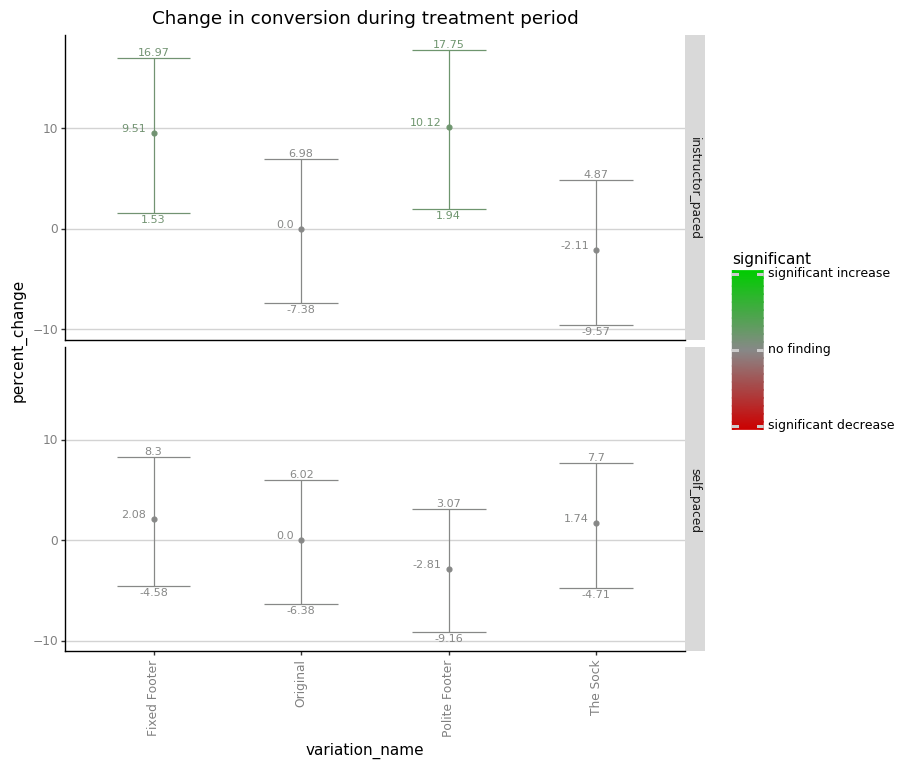

<ggplot: (-9223363284384329030)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer       1.527994        9.507103    16.973664   
                 Original          -7.380444        0.000000     6.983355   
                 Polite Footer      1.939794       10.124766    17.749095   
                 The Sock          -9.571793       -2.105116     4.870067   
self_paced       Fixed Footer      -4.578674        2.079760     8.300231   
                 Original          -6.379586        0.000000     6.018329   
                 Polite Footer     -9.160724       -2.813858     3.065731   
                 The Sock          -4.706897        1.738027     7.700318   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.160721  
                 Original           0.000000  
                 Polite Footer      0.191589  
                 The Sock           0.000000  
self_paced       Fixed Footer       0.000000  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000

In [12]:
compute(
    'verified_during_treatment',
    'Change in conversion during treatment period'
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


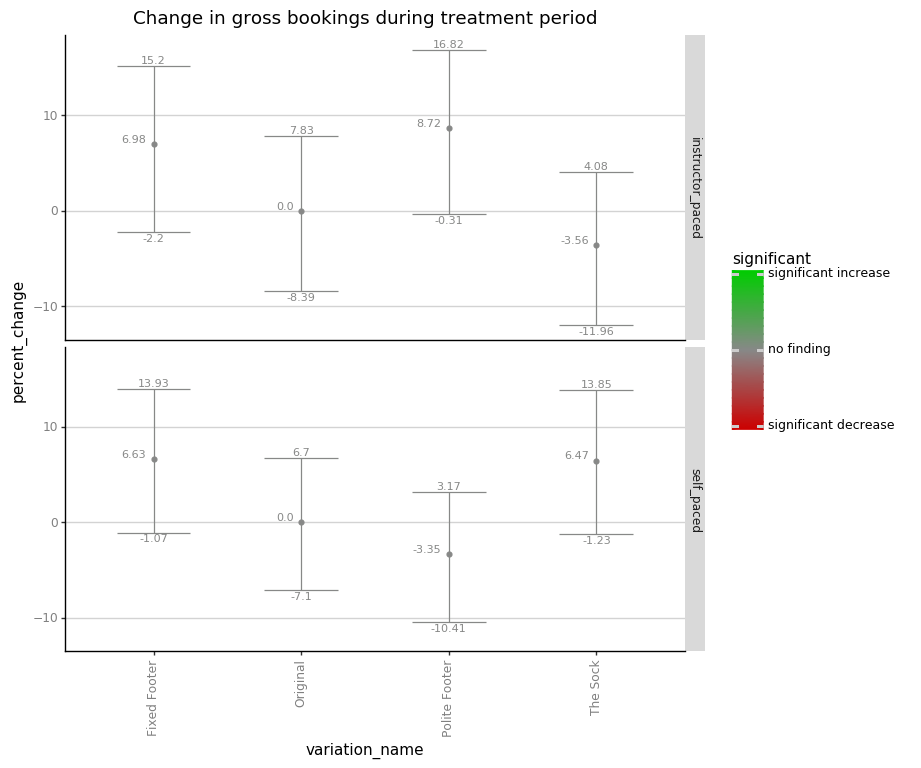

<ggplot: (8752471730219)>

In [13]:
bookings_conf_intervals = compute(
    'gross_bookings_during_treatment',
    'Change in gross bookings during treatment period'
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


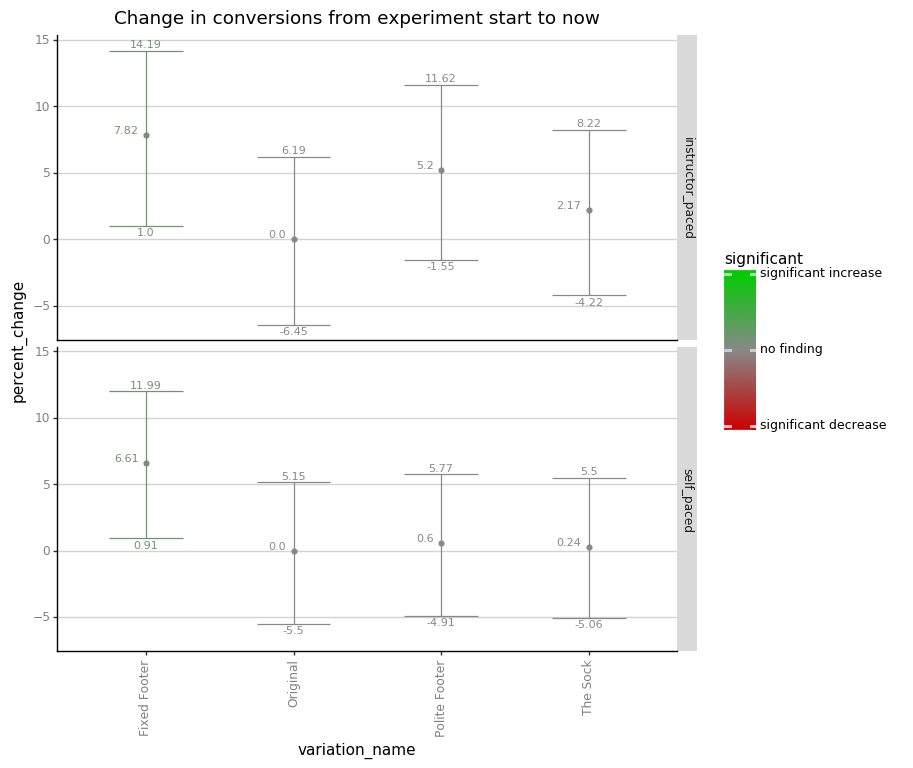

<ggplot: (-9223363284373093260)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer       1.003862        7.821518    14.187240   
                 Original          -6.446836        0.000000     6.193078   
                 Polite Footer     -1.545700        5.197714    11.621034   
                 The Sock          -4.224559        2.169033     8.222647   
self_paced       Fixed Footer       0.912553        6.614597    11.988470   
                 Original          -5.496189        0.000000     5.148005   
                 Polite Footer     -4.912372        0.603566     5.768533   
                 The Sock          -5.064593        0.243097     5.497957   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.128346  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000  
self_paced       Fixed Footer       0.137960  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000

In [14]:
compute(
    'verified',
    'Change in conversions from experiment start to now'
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


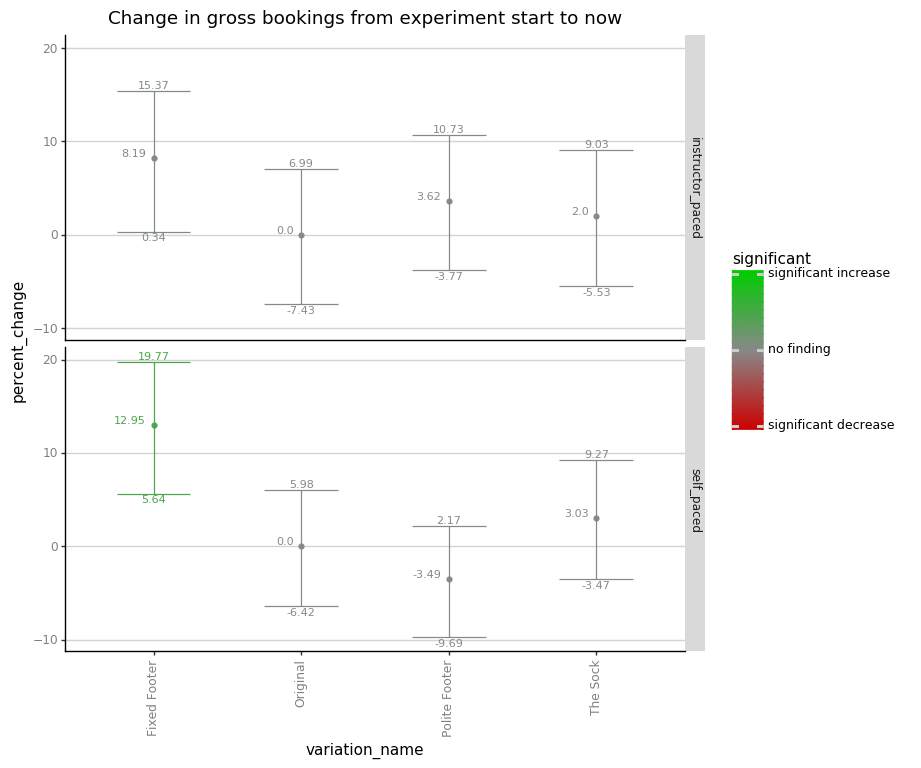

<ggplot: (-9223363284383031485)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer       0.337717        8.191970    15.371498   
                 Original          -7.425414        0.000000     6.994088   
                 Polite Footer     -3.773993        3.624304    10.732989   
                 The Sock          -5.527830        1.999700     9.030634   
self_paced       Fixed Footer       5.637498       12.947813    19.769416   
                 Original          -6.422698        0.000000     5.978535   
                 Polite Footer     -9.689419       -3.485864     2.174440   
                 The Sock          -3.474303        3.028725     9.270733   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.041225  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000  
self_paced       Fixed Footer       0.435402  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000

In [15]:
compute(
    'gross_bookings',
    'Change in gross bookings from experiment start to now'
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


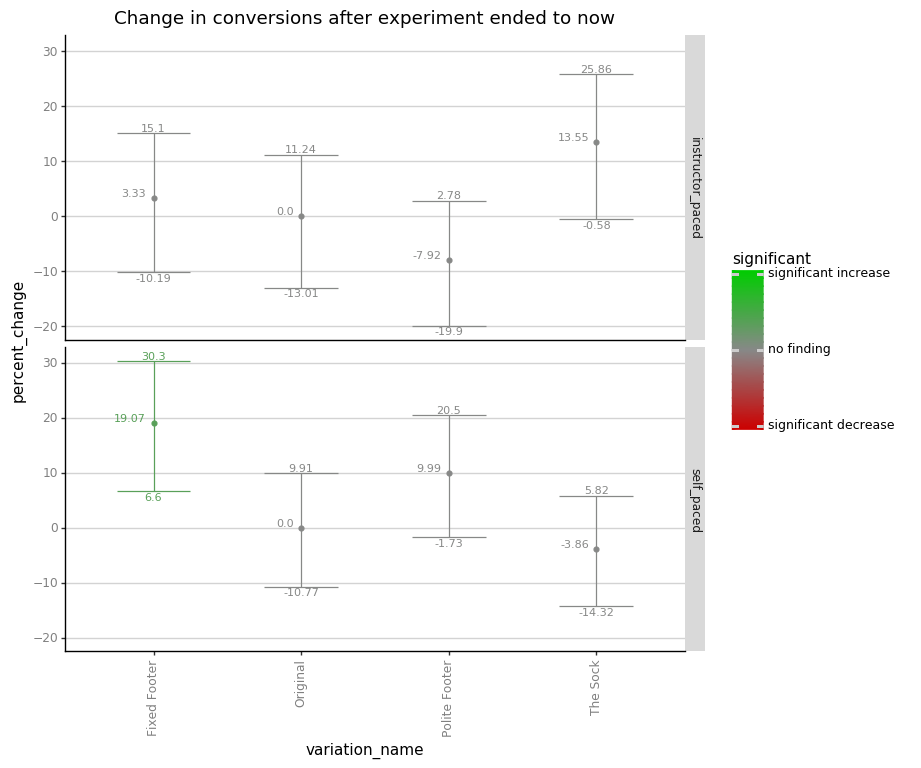

<ggplot: (8752471457719)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer     -10.194513        3.334215    15.101462   
                 Original         -13.013699        0.000000    11.236952   
                 Polite Footer    -19.897773       -7.918896     2.782865   
                 The Sock          -0.582121       13.547510    25.859891   
self_paced       Fixed Footer       6.601264       19.068480    30.300840   
                 Original         -10.769231        0.000000     9.905660   
                 Polite Footer     -1.731050        9.988729    20.497482   
                 The Sock         -14.324919       -3.862381     5.818878   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.000000  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000  
self_paced       Fixed Footer       0.346187  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000

In [16]:
compute(
    'verified_after_treatment',
    'Change in conversions after experiment ended to now'
)

/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


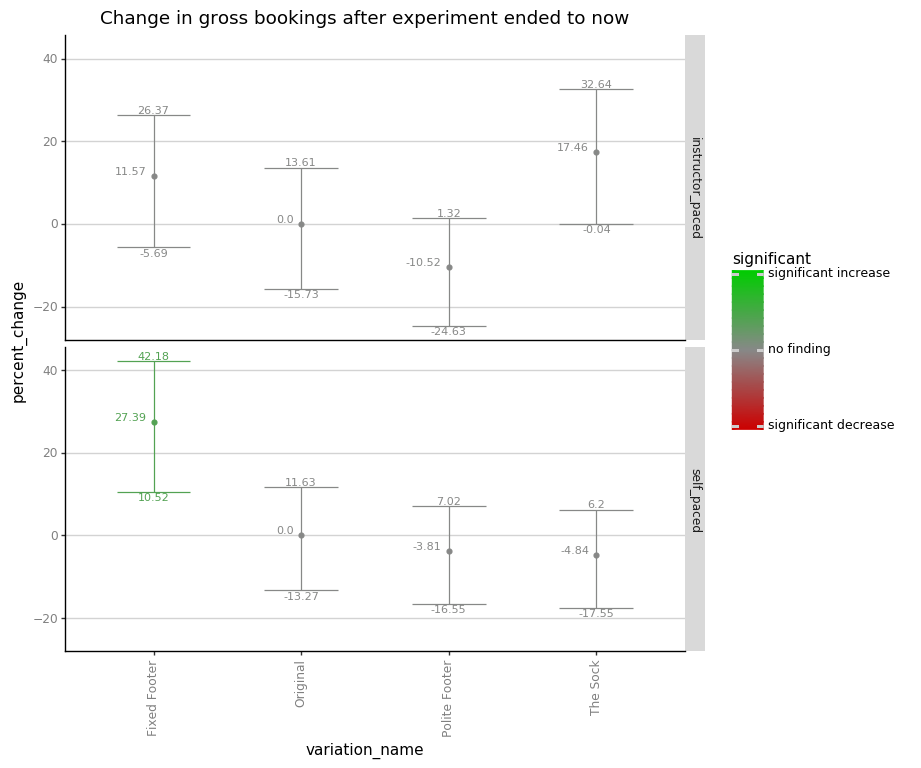

<ggplot: (8752481682454)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer      -5.689762       11.565792    26.374698   
                 Original         -15.730299        0.000000    13.606208   
                 Polite Footer    -24.629606      -10.523841     1.318889   
                 The Sock          -0.035885       17.462774    32.643741   
self_paced       Fixed Footer      10.516661       27.387341    42.183714   
                 Original         -13.271456        0.000000    11.631415   
                 Polite Footer    -16.554841       -3.807602     7.020393   
                 The Sock         -17.551158       -4.837790     6.197244   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.000000  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000  
self_paced       Fixed Footer       0.383997  
                 Original           0.000000  
                 Polite Footer      0.000000  
                 The Sock           0.000000

In [17]:
compute(
    'gross_bookings_after_treatment',
    'Change in gross bookings after experiment ended to now'
)

In [18]:
bookings_by_group = conversions.reset_index().groupby(['pacing_type', 'variation_name']).sum().gross_bookings

In [19]:
improvement_range = bookings_conf_intervals.loc[('instructor_paced', 'Fixed Footer')]
baseline_bookings = bookings_by_group.loc[('instructor_paced', 'Original')]
low = baseline_bookings * (improvement_range.lower_bound / 100)
print(low * 3 * 52)
expected = baseline_bookings * (improvement_range.percent_change / 100)
print(expected * 3 * 52)
high = baseline_bookings * (improvement_range.upper_bound / 100)
print(high * 3 * 52)

-205303.698045
651331.69559
1418992.1686


In [20]:
improvement_range = bookings_conf_intervals.loc[('instructor_paced', 'Polite Footer')]
baseline_bookings = bookings_by_group.loc[('instructor_paced', 'Original')]
low = baseline_bookings * (improvement_range.lower_bound / 100)
print(low * 3 * 52)
expected = baseline_bookings * (improvement_range.percent_change / 100)
print(expected * 3 * 52)
high = baseline_bookings * (improvement_range.upper_bound / 100)
print(high * 3 * 52)

-28908.4342633
813552.670079
1569668.68293
